In [5]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#from sklearn import preprocessing
import unittest
pd.set_option('display.max_rows', 30)

---

# 1. Introduction

In this analysis I will use international trade data and social network analysis (SNA) techniques to understand the economic importance of countries. I also include a second dataset on GDP per capita for the visualisation. The analysis consists of two stages: first, I calculate a range of centrality measures for all countries available in 2019, visualise the results and discuss the merits of each centrality measure. The second stage uses the same centrality measures to understand how the United Kingdom's international importance as a trading partner changed following the Brexit vote in 2016.

I first import, clean and explore the internation trade dataset and merge the GDP data, then run the SNA and provide visualisations. At the end of my analysis I conclude and finally run unit tests on functions created.

---

# 2a. Import and clean IMF international trade data

The data is collected by the IMF for all reporting countries. The data is collated by a Kaggle user and can be accessed [here](https://www.kaggle.com/datasets/appetukhov/international-trade-database). Each row reports the exporting country, the importing country and an export value in a given year.

In [6]:
# Import exports data from https://www.kaggle.com/datasets/appetukhov/international-trade-database
exports_raw = pd.read_csv('trade_1988_2021.csv')
exports_raw.head(3)

FileNotFoundError: [Errno 2] No such file or directory: 'trade_1988_2021.csv'

In [ ]:
# Confirm all values are export figures
exports_raw['TradeFlowName'].value_counts()

Here we see all rows are export values - therefore I rename the columns and drop the trade flow column.

In [ ]:
# Rename columns making sure to specify exports in the value name
exports_raw.rename(columns = {'ReporterISO3': 'reporter_iso_3',
                                'ReporterName': 'reporter_name',
                                'PartnerISO3': 'partner_iso_3',
                                'PartnerName': 'partner_name',
                                'TradeValue in 1000 USD': 'export_value_in_1000_usd',
                                'Year': 'year'}, inplace = True)

# Drop trade flow column as it provides no additional information
exports_raw.drop(['TradeFlowName'], axis = 1, inplace = True)
exports_raw.head(3)

Check for duplicate rows

In [ ]:
# Check for duplicates across exporter, importer and year
exports_raw.loc[:,['reporter_iso_3', 'partner_iso_3', 'year']].duplicated().value_counts() # False value indicates row is not duplicated

### Visualise the value column

In order to understand the distribution of the values better, I plot a simple box plot.

In [ ]:
# Plot a simple box plot to understand the range of values in the export value column 
exports_raw['export_value_in_1000_usd'].plot.box(figsize=(8,6))

This plot shows that the median export value is small, but there are some very high outlier values.

From this I investigate both ends of this spectrum to understand if there are erroneous entries.

In [ ]:
exports_raw.sort_values('export_value_in_1000_usd').head(3)

Here we can see that there are zero-valued entries - the dataset is, at least to some extent, dense. As they indicate there is no trade relationship, they should be dropped from the analysis making the dataset sparse.

I also drop missing values and other values too low to be considered a trading relationship. I used the value of $1,000 as the cut-off. As I will discuss later, this decision has potential to have significant impacts on the centrality measures and should be checked for robustness.

In [ ]:
# View rows with missing export values
exports_raw[exports_raw['export_value_in_1000_usd'].isna()].head()

In [ ]:
# Drop rows with missing values or values less than $1,000
exports_raw.dropna(axis = 0, inplace = True)
max_value = 1
exports_raw = exports_raw[exports_raw['export_value_in_1000_usd'] >= max_value] 
exports_raw.info()

I now turn to the largest values in the dataset.

In [ ]:
exports_raw.sort_values('export_value_in_1000_usd', ascending = False).head(10)

Here we observe that we have non-country-to-country relationships in the dataset such as 'World' and 'European Union'. As we are interested in country-to-country relationships, these must be dropped.

To do this I manually sifted through the unique values in both the reporter and partner name columns. Some countries do not take their usual English name but are kept in the analysis. For example, 'Other Asia, nes' refers to Taiwan and 'Occ.Pal.Terr' is the Occupied Palestinian Territory.

In [ ]:
print(pd.DataFrame(exports_raw['reporter_name'].unique()).head())

In [ ]:
# Remove observations where the reporter is not a country
reporter_drop = ['European Union']

exports_raw.drop(exports_raw[exports_raw['reporter_name'].isin(reporter_drop)].index, inplace = True)

In [ ]:
print(pd.DataFrame(exports_raw['partner_name'].unique()).head())

In [ ]:
# Remove any observations where the partner is undefined or not a country. 
partner_drop = ['Unspecified', ' World', 'Bunkers', 'Free Zones', 'Special Categories', 'Neutral Zone', 'European Union']

exports_raw[exports_raw['partner_name'].isin(partner_drop)]['partner_name'].value_counts()
exports_raw.drop(exports_raw[exports_raw['partner_name'].isin(partner_drop)].index, inplace = True)

I noticed that there are two values relating to Ethiopia, representing pre and post-Eritrean independence. It is important for later centrality calculations that countries are not double counted in the same time period so I run a quick check.

In [ ]:
# Check that Ethiopia is not double counted
excl_year = set(exports_raw[exports_raw['partner_name'] == 'Ethiopia(excludes Eritrea)']['year'])
incl_year = set(exports_raw[exports_raw['partner_name'] == 'Ethiopia(includes Eritrea)']['year'])

if (len(excl_year.intersection(incl_year)) == 0):
    print("There is no overlap in Ethiopian dates.")   

Finally, I plot the total export value over time to understand if there is anything interesting to note.

In [ ]:
# Plot total export value figure by year
plt.figure()
exports_raw.groupby('year')['export_value_in_1000_usd'].sum().plot(figsize=(6,6))

Here we can see an sharp unexpected drop in 2021. On inspection, this is because not all countries have reported data, including large countries such as China. It seems like the decreases in 2009 and 2016/7 are consistent with [other sources](https://www.statista.com/statistics/264682/worldwide-export-volume-in-the-trade-since-1950/).

In [ ]:
exports_raw.groupby('year')['reporter_name'].nunique().tail(10)

There is also a slight drop-off in reporters in 2019 - a year we will be using in our analysis. I inspect which countries are present in 2018 and not 2019, and vice-versa. Later in the analysis I also perform a robustness check on the post-Brexit year used.

In [ ]:
a = set(exports_raw[exports_raw['year'] == 2018]['reporter_name'])
b = set(exports_raw[exports_raw['year'] == 2019]['reporter_name'])
#print(a-b)
print(f'Countries in 2018, not 2019: {a - b} \n\n Countries in 2019, not 2018: {b - a}')

# 2b. Import GDP per capita data

GDP per capita data is imported and merged into the main dataset. The GDP data is collected by the [WorldBank](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD).

I import, clean and reshape the data to match the trade dataset.

In [ ]:
# Import data from https://data.worldbank.org/indicator/NY.GDP.PCAP.CD
gdp = pd.read_csv('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4701206.csv', skiprows = 2)

# Drop unused columns
gdp.drop(['Indicator Name', 'Indicator Code','Country Name'], axis = 1, inplace = True)

# Reshape into long format with a single column for year
gdp = gdp.melt(id_vars = ['Country Code'], 
               var_name = 'Years')

# Clean column names
gdp.rename(columns = {'Country Code': 'reporter_iso_3',
                    'Country Name': 'reporter_name',
                    'value': 'gdp_per_capita',
                    'Years': 'year'}, inplace = True)

# Convert the year column to a numeric. Missing values are coerced to NaN
gdp["year"] = pd.to_numeric(gdp["year"], errors = 'coerce')
gdp.head()

## Merge the datasets

In [ ]:
exports = exports_raw.merge(gdp, on = ['reporter_iso_3', 'year'], how = 'left')
exports.head(3)

In [ ]:
exports.isnull().sum()

Although there are many missing values, all countries that are visualised are matched. The values also don't impact the results of the analysis.

In [22]:
# Filter on year for 2015 and 2019
exports_2015 = exports[exports['year']==2015]
exports_2019 = exports[exports['year']==2019]

In [23]:
exports_2019.sort_values('export_value_in_1000_usd', ascending = False).head()

,reporter_iso_3,reporter_name,partner_iso_3,partner_name,year,export_value_in_1000_usd,gdp_per_capita
99615,CHN,China,USA,United States,2019,4.185842e+08,10143.838196
346537,MEX,Mexico,USA,United States,2019,3.586385e+08,9950.217622
86652,CAN,Canada,USA,United States,2019,3.057721e+08,46328.671841
216233,HKG,"Hong Kong, China",CHN,China,2019,2.960690e+08,48356.063504
99412,CHN,China,HKG,"Hong Kong, China",2019,2.796167e+08,10143.838196


I run a final visualisation of the cleaned export values for 2019.

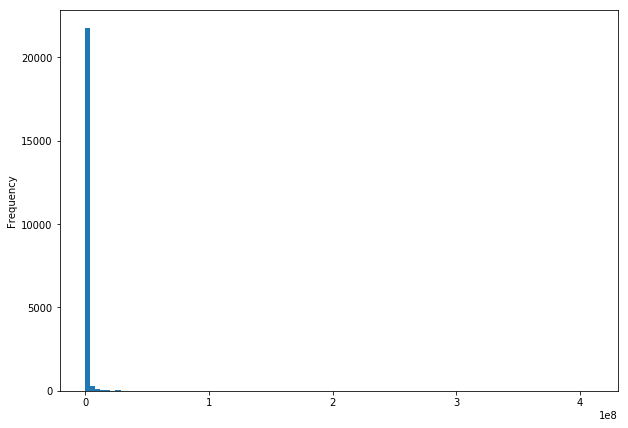

In [24]:
exports_2015['export_value_in_1000_usd'].plot.hist(figsize=(10,7), bins = 100)

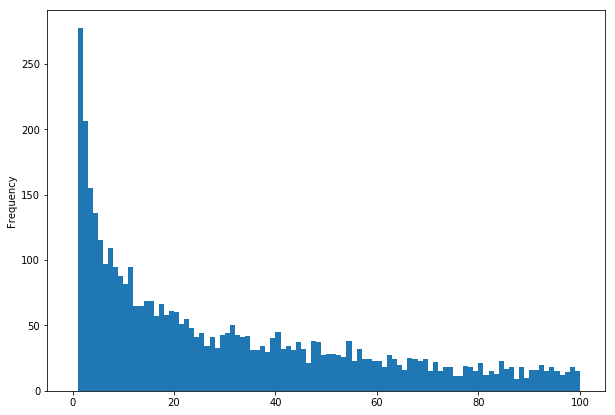

In [25]:
exports_2015['export_value_in_1000_usd'].plot.hist(figsize=(10,7), range = (0, 100), bins = 100)

The distribution of the export values remains to be heavily skewed to the right with many small values and fewer very large values.

Although I would expect there to be many small trade relationships, I am surprised by how heavily skewed the data is; making the decision of minimum cut-off value more important. With more time I would like to have checked the robustness of the results to different data max value cutoffs.

# 3. Social network analysis

## 3a. All countries, 2019

I will first create a digraph using all countries for which we have data available in 2019; this will form the basis of the analysis. I then create a sub-digraph of the same analysis but only showing countires involved in trade relationships of value greater than $100,000,000,000.

This is contrary to suggestions from [Zhou (2020)](https://doi.org/10.1093/oxfordhb/9780190251765.013.36), in which the author suggests to filter the underlying data before creating the graphs. Pre-filtering the data will have significant impacts on the centrality measures depending on how the filters are applied. As this analysis focuses on centrality measures across the complete set of countries and filtering is only for visualisation, I opt to create subgraphs based on centrality figures from the complete clean dataset.

### Graph for analysis

In [26]:
# Set edge values
G_2019 = nx.from_pandas_edgelist(exports_2019,
                           source='reporter_name',
                           target='partner_name',
                           edge_attr='export_value_in_1000_usd',
                           create_using=nx.DiGraph())
# Set node values
nodes_attr = exports_2019.loc[:,['reporter_name', 'gdp_per_capita']].drop_duplicates().set_index('reporter_name').to_dict(orient = 'index')
nx.set_node_attributes(G_2019, nodes_attr)

# Print information
density = round(nx.density(G_2019), 2)
strong = nx.number_strongly_connected_components(G_2019)
weak = nx.number_weakly_connected_components(G_2019)
print(nx.info(G_2019))
print(f'Density: {density} \nNumber of strongly connected components: {strong} \nNumber of weakly connected components: {weak}' )



Name: 
Type: DiGraph
Number of nodes: 234
Number of edges: 21611
Average in degree:  92.3547
Average out degree:  92.3547
Density: 0.4 
Number of strongly connected components: 81 
Number of weakly connected components: 1


We can see that there are 234 countries (nodes) and 21,611 trade relationships (edges). 

In this analysis out-degrees represent the reference country exporting to another and in-degrees represent the reference country being exported to (for the purposes of this analysis I will refer to importing, although there are [some measurement differences](https://datahelp.imf.org/knowledgebase/articles/484353-why-do-the-exports-of-country-a-to-country-b-not-e)).

On average, each country has 92 countries that they export to and 92 countries that they import from. This is because any in-degree to one node is an equivalent out-degree from another node and therefore the averages are equal.

To get a clearer picture of the relationships I plot histograms of the in and out degrees.

I first create a function to produce plots of the degree distribution with different functionality depending on whether the the graph is directional. The function will also capture an error if a non-graph object is parsed.

In [27]:
def plot_degree_dist(G):
    """Takes a networkx graph object and produces a degree distribution 
    chart for non-directional and in and out-degree distribution charts for directional graphs.
    For directional charts, it also calculated the number of countries reported as importers
    but not exporters.
    
    : param G: A networkx graph
    
    : return: A message depending on the graph type
    """
    
    try:
        # If graph is non-directional plot degree distribution
        if type(G) == nx.classes.graph.Graph:
            degrees = [G.degree(n) for n in G.nodes()]
            plt.hist(degrees)
            plt.title('Degree distribution')
            plt.show()
            mess = 'Warning: The graph specified is non-directional.'
                        
        # If graph is directional plot in and out degree distribution
        elif type(G) == nx.classes.digraph.DiGraph:
            in_degrees = [G.in_degree(n) for n in G.nodes()]
            plt.hist(in_degrees)
            plt.title('In-degree distribution')
            plt.show()

            out_degrees = [G.out_degree(n) for n in G.nodes()]
            plt.hist(out_degrees)
            plt.title('Out-degree distribution')
            plt.show()

            # Calculate the countries reported as importer but without reporting exports
            count_zero = [G.out_degree(n) for n in G.nodes()].count(0)
            mess = f'There are {count_zero} countries that are reported as export partners but do not report exports themselves.'
            
        # Otherwise raise a type error
        else:
            raise TypeError()
        
    # Plot degree distribution if there is no in-degree attribute
    except TypeError:
        return f'Error: plot_degree_dist does not accept {type(G)}. Please enter a NetworkX graph.'
        
    # If no error is captured, return the message
    else:
        return mess


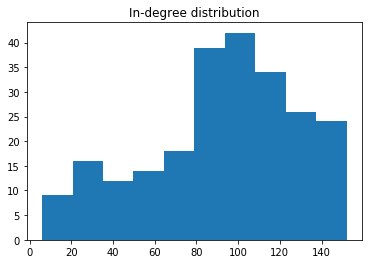

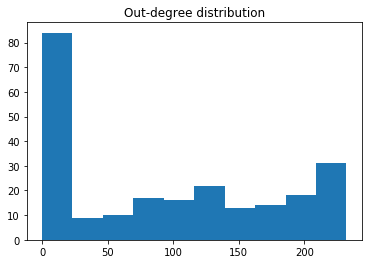

'There are 80 countries that are reported as export partners but do not report exports themselves.'

In [28]:
plot_degree_dist(G_2019)

Later I will discuss the impact on centrality measures from missing export data.

Now, thinking about how to visualise the data, one of the biggest design choices in this analysis is in how to filter the countries to make a useful visualisation. Here I have decided to identify parties - either exporter or importer - involved in exports of value greater than $100,000,000,000.

This is because I am most interested in larger countries with greater trade influence. However, as not all of the centrality measures are weighted by trade value, there is good chance some of the more 'central' nodes are not visualised. Given more time, I would like to have provided different cuts of the data for visualisation.

In [29]:
# Identify parties in large trade relationships
large_value = 1e+08
large_reporter = set(exports_2019[exports_2019['export_value_in_1000_usd'] > large_value]['reporter_name'])
large_partner = set(exports_2019[exports_2019['export_value_in_1000_usd'] > large_value]['partner_name'])
large_parties = list(large_reporter | large_partner)
large_parties.sort()
print(f'The countries visualised in the analysis are: '+', '.join(large_parties))

The countries visualised in the analysis are: Australia, Canada, China, France, Germany, Hong Kong, China, Japan, Korea, Rep., Mexico, Netherlands, United States


### Calculate centrality measures

I can then define a function to create a dataframe from the centrality values for each node - again with exception handling. In this function we catch a NetworkXError in cases where eccentricity can not be calculated due to the graph not being connected.

In [30]:
def centrality_table_maker(G)-> pd.DataFrame:
    """Creates a pandas dataframe containing the different centrality measures for each node in a digraph.
    
    :param G: A networkx digraph
    
    :returns measures: A pandas dataframe
    """
    try:
        in_deg = nx.in_degree_centrality(G)
        out_deg = nx.out_degree_centrality(G)
        in_close = nx.closeness_centrality(G) # uses the edge attribute as distance value
        out_close = nx.closeness_centrality(G.reverse())
        bet = nx.betweenness_centrality(G, weight = 'export_value_in_1000_usd')
        eig = nx.eigenvector_centrality(G, max_iter = 1000, weight = 'export_value_in_1000_usd')
        ecc = nx.eccentricity(G.to_undirected())
        measures = pd.DataFrame({'in_degree_centrality': in_deg,
                         'out_degree_centrality': out_deg,
                         'in_closeness_centrality': in_close,
                         'out_closeness_centrality': out_close,
                         'betweenness_centrality': bet,
                         'eigenvector_centrality': eig,
                         'eccentricity': ecc})
        return measures
        
    
    # Create an exception for when graph is not connected and, therefore, eccentricity can't be calculated.
    except nx.NetworkXError:
        in_deg = nx.in_degree_centrality(G)
        out_deg = nx.out_degree_centrality(G)
        in_close = nx.closeness_centrality(G) # uses the edge attribute as distance value
        out_close = nx.closeness_centrality(G.reverse())
        bet = nx.betweenness_centrality(G, weight = 'export_value_in_1000_usd')
        eig = nx.eigenvector_centrality(G, max_iter = 1000, weight = 'export_value_in_1000_usd')
        measures = pd.DataFrame({'in_degree_centrality': in_deg,
                         'out_degree_centrality': out_deg,
                         'in_closeness_centrality': in_close,
                         'out_closeness_centrality': out_close,
                         'betweenness_centrality': bet,
                         'eigenvector_centrality': eig})
        return measures

In [31]:
G_2019_centrality = centrality_table_maker(G_2019)
G_2019_centrality.head()

,in_degree_centrality,out_degree_centrality,in_closeness_centrality,out_closeness_centrality,betweenness_centrality,eigenvector_centrality,eccentricity
Afghanistan,0.407725,0.274678,0.476151,0.579602,0.014374,0.001291,2
Central African Republic,0.369099,0.000000,0.458493,0.000000,0.000000,0.000074,2
Canada,0.643777,0.939914,0.644024,0.943320,0.000388,0.268265,2
Switzerland,0.609442,0.944206,0.612609,0.947154,0.000425,0.055258,2
China,0.639485,0.918455,0.639922,0.924603,0.000203,0.364433,2


### Plot subgraphs

I now create a function that takes a digraph and a subset of countries to include in the visualisation to create a subgraph for each centrality measure and eccentricity, along with a summary table.

I have chosen not to use a cartographic representation and rather to use force-directed graph drawing algorithms. As the geographic locations of countries do not directly impact the interpretation of my results, adding catographic features would be unnecessarily restrictive [(Benedictis et al., 2014)](http://www.cepii.fr/pdf_pub/wp/2013/wp2013-24.pdf). Rather I use the Fruchterman-Reingold force-directed algorithm available in networkx's spring_layout function. The algorithm strives to minimise edge crossing, provide similar edge lengths and to have an even distribution of nodes [(Fruchterman and Reingold, 1991)](http://dx.doi.org/10.1002/spe.4380211102) - together these attributes make the graph more aestheticly pleasing and easier to interpret.

The node colour is a prefered way of representing the main analytical result, centrality, as is easier for the reader to identify which countries have high centrality values. When using the node size, this distinction is more difficult.

Line width represents the edge value, in this case the export value, and node size represents the country's GDP per capita, a figure of secondary interest to the analysis.

In [32]:
def subgraph_maker(G, subsetter: list) -> pd.DataFrame:
    """Create subgraphs based on networkx graph object and a list of countries.
    
    :param G: A networkx digraph.
    :param subsetter: list of subset countries to be included in the visualisation.
    
    :return plots and dataframe of centrality values.
    """
    try: 
        centrality_table = centrality_table_maker(G)
        
        # Attribute the centrality values calculated in the centrality table to the graph nodes
        for i in range(len(centrality_table.columns)):
            # Set node values
            cent = centrality_table.iloc[:,i].to_frame().to_dict(orient = 'index')
            name = centrality_table.columns[i]
            nx.set_node_attributes(G, cent)

        # Create graph subset based on the list presented
        G_sub = G.subgraph(subsetter)
        
        # Test whether GDP attributes are shorter than the length of subsetter
        if len(list(nx.get_node_attributes(G_sub,'gdp_per_capita').values())) < len(subsetter):
            raise IndexError()
        #x = len(subsetter)-1
        #print(x)
        #sizes = list(nx.get_node_attributes(G_sub,'gdp_per_capita').values())[x]

        
    # Raise index error if missing GDP data
    except IndexError:
        # Find which country is missing GDP data and flag in the exception
        in_lst = set(nx.get_node_attributes(G_sub,'gdp_per_capita').keys())
        sub_set = set(subsetter)
        return f'Error: Missing GDP per capita data for: {sub_set - in_lst}'
        
    # If GDP attributes are not shorter than subsetter, produce charts and table
    else:
        # Loop through each centrality measure and eccentricity. Then produce
        # a subgraph for each using the node colour and edge width
        for i in range(len(centrality_table.columns)):

            # Set the random seed and positioning algorithm
            np.random.seed(75)
            pos = nx.spring_layout(G_sub)

            # Create edge and node features to be represented in the visualisation
            fig = plt.figure(figsize=(9,7))
            weights = [x/1e+8 for x in list(nx.get_edge_attributes(G_sub,'export_value_in_1000_usd').values())]
            sizes = [x/30 for x in list(nx.get_node_attributes(G_sub,'gdp_per_capita').values())]
            color = [x for x in list(nx.get_node_attributes(G_sub, G_2019_centrality.columns[i]).values())] # filter the centrality table based on subgroup

            # Draw visualisation

            # Labels
            labels = nx.draw_networkx_labels(G_sub, pos,font_color="dimgrey")
            # Nodes
            nodes = nx.draw_networkx_nodes(G_sub, 
                                           pos, 
                                           node_size=sizes, 
                                           cmap=plt.cm.plasma, 
                                           node_color=color)
            nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
            # Edges
            edges = nx.draw_networkx_edges(G_sub, pos, width = weights, node_size = sizes)

            plt.title(centrality_table.columns[i])
            plt.colorbar(nodes, format = '%0.2f')
            plt.axis('off')
            plt.show()

        # Create and return an output table
        centrality_table_filter = centrality_table.loc[subsetter,:]       
        return centrality_table_filter

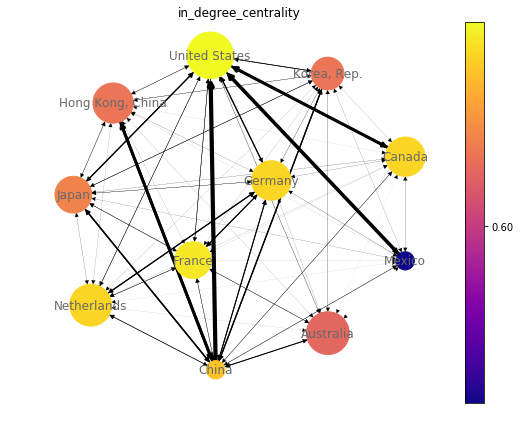

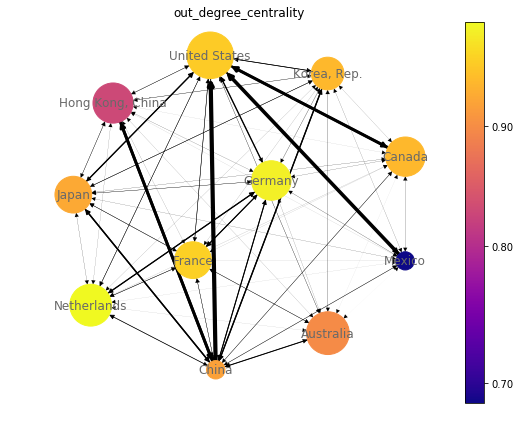

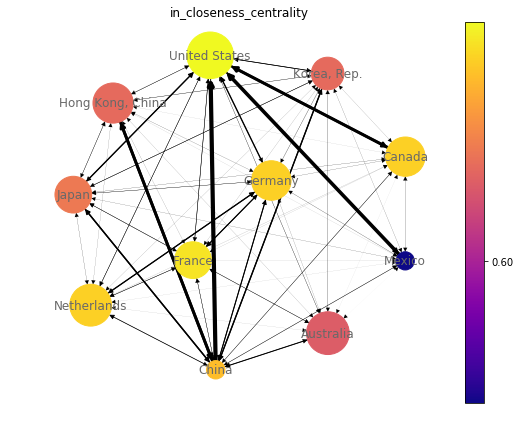

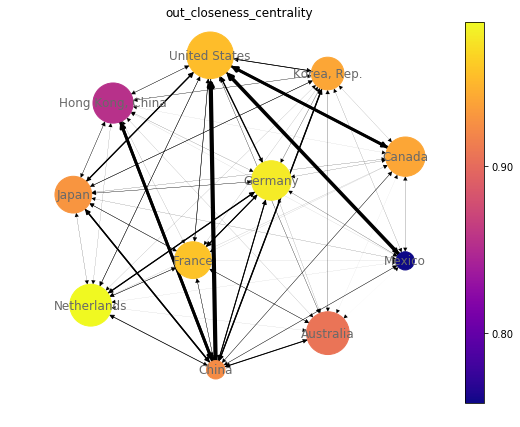

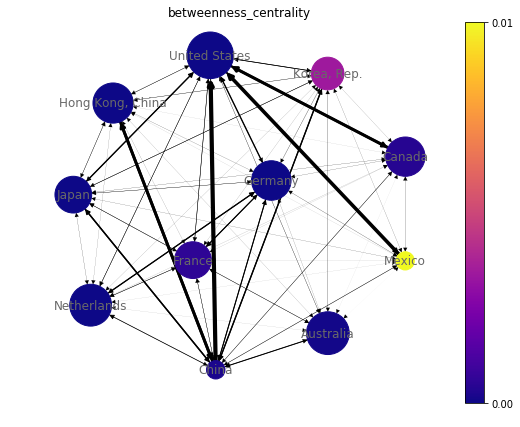

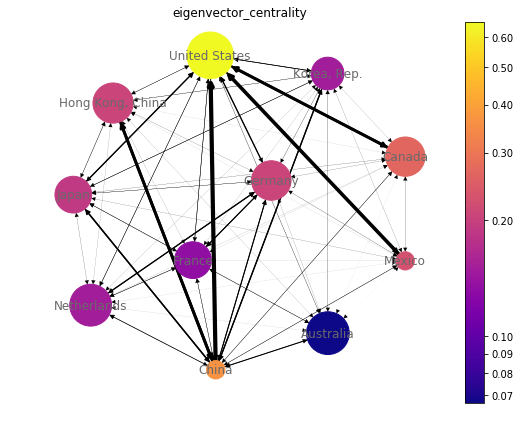

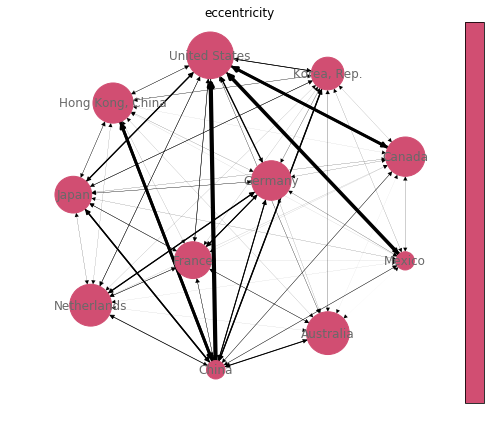

,in_degree_centrality,out_degree_centrality,in_closeness_centrality,out_closeness_centrality,betweenness_centrality,eigenvector_centrality,eccentricity
Australia,0.613734,0.896996,0.616367,0.906615,0.000092,0.066991,2
Canada,0.643777,0.939914,0.644024,0.943320,0.000388,0.268265,2
China,0.639485,0.918455,0.639922,0.924603,0.000203,0.364433,2
France,0.648069,0.961373,0.648179,0.962810,0.000555,0.133816,2
Germany,0.643777,0.987124,0.644024,0.987288,0.000000,0.206804,2
"Hong Kong, China",0.618026,0.828326,0.620172,0.853480,0.000000,0.206174,2
Japan,0.622318,0.927039,0.624024,0.932000,0.000000,0.189853,2
"Korea, Rep.",0.618026,0.939914,0.620172,0.943320,0.003274,0.150286,2
Mexico,0.557940,0.686695,0.570840,0.761438,0.009583,0.228728,2
Netherlands,0.643777,0.995708,0.644024,0.995726,0.000000,0.150387,2


In [33]:
subgraph_maker(G_2019, large_parties)

### Indentify countries with the maximum centrality values

In [34]:
for j in G_2019_centrality.columns:
    top = G_2019_centrality[G_2019_centrality[j] == G_2019_centrality[j].max()].index[:].to_list()
    print(f'Maximum {j}: '+', '.join(top) +'\n')

Maximum in_degree_centrality: United States

Maximum out_degree_centrality: Netherlands

Maximum in_closeness_centrality: United States

Maximum out_closeness_centrality: Netherlands

Maximum betweenness_centrality: Eswatini

Maximum eigenvector_centrality: United States

Maximum eccentricity: Afghanistan, Central African Republic, Canada, Switzerland, China, Czech Republic, Germany, Denmark, Egypt, Arab Rep., Spain, Finland, France, United Kingdom, Georgia, Hong Kong, China, Belarus, Indonesia, Iran, Islamic Rep., Iraq, Italy, Jordan, Japan, Kazakhstan, Kyrgyz Republic, Korea, Rep., Kuwait, Lebanon, Lithuania, Latvia, Morocco, Myanmar, India, Bahrain, Bangladesh, Belgium, Azerbaijan, Austria, Australia, United Arab Emirates, Malaysia, Namibia, Norway, Nepal, Other Asia, nes, Oman, Pakistan, Poland, Portugal, Qatar, Romania, Russian Federation, Saudi Arabia, Singapore, Somalia, Sweden, Eswatini, Thailand, Tajikistan, Netherlands, Vietnam, Uzbekistan, United States, Ukraine, Turkey, Tur

In [35]:
G_2019_centrality['eccentricity'].value_counts()

2    234
Name: eccentricity, dtype: int64

All countries have eccentricity of 2.

## Summary of the results

The high out-degree compared to in-degree (equally, closeness) figures are a result of incomplete or non-existant data from some countries, as identified earlier using degree distributions. This result reflects the impetus behind [Sajedianfard et al. (2021)](https://appliednetsci.springeropen.com/articles/10.1007/s41109-021-00386-3) in which the authors develop this IMF dataset using a mirror statistic strategy. By attributing the exports and imports from reporting countries to imports and exports for non-reporting countries, they are able to account for smaller countries with less reporting infrastructure. This then significantly reduces the difference between in and out-degree centrality measures. This would be one way of further developing this analysis.

From the centrality measures, we can see that the US has the highest measures of inwards degree and closeness centrality. Whereas the Netherlands has the highest measures of outwards degree and closeness measures. Degree centrality calculates how well connected a node is to all other nodes by calculating the number of actual in or out degrees divided by the total number of potential connections.
 
$C_{D_{i}} = \frac{\sum_{j=i}^{n} a_{i,j}}{n-1}$

where: 
- $C_{D_{i}}$ is the in (respectively, out) degree centrality,

- $a_{i, j}$ is a binary indicator of an existing in (respectively, out) degree edge between nodes $i$ and $j$, and

- $n$ is the total number of nodes.


Here we are using an unweighted centrality measure on a digraph without self-loops, therefore, the adjacency matrix is square, binary, asymmetric and has a zero diagonal. The analysis shows that the Netherlands has the highest proportion of potential export relationships realised at 0.996. The US is reported as having the highest proportion of import relationship at 0.652. However, the data completeness makes in-degree analysis unreliable.

Closeness centrality is a 'global' centrality measure in that the calculation for each node accounts for all other relationships in the graph [(Benedictis, 2014)](http://www.cepii.fr/pdf_pub/wp/2013/wp2013-24.pdf). The closeness measures account for the geodesic distance between nodes - what the shortest path between them is. The more steps between one country and another, the lower the closeness centrality measure.

$C_{C_i} = \frac{n-1}{\sum_{i=1}^{n-1}d(i, j)}$

where: 
- $C_{C_{i}}$ is the closeness centrality,

- $d(i, j)$ is the shortest distance between nodes $i$ and $j$, and

- $n$ is the total number of nodes.


It is interesting to see that the same countries have the highest centrality for both in and out degree and closeness measures. This reflects the highly connected global trade system - there are very few countries with eccentricities greater than two. Research also finds that degree and closeness centrality are closely correlated [(Bolland, 1988)](https://www.sciencedirect.com/science/article/abs/pii/0378873388900147). Again the measure is unweighted and, therefore, also uses the same adjacency matrix as for degree centrality. 

Perhaps surprisingly, Eswantini has the highest level of betweenness centrality. Betweenness centrality measures the propensity of a node to sit on the shortest path between two other nodes. [Benedictis (2014)](http://www.cepii.fr/pdf_pub/wp/2013/wp2013-24.pdf) states that betweenness centrality 'is not well suited for an application to bilateral trade relationships'. I would agree with this statement for modern trade relationship data in which the graph diameter is very small. Therefore, there are often no nodes on the shortest path between other nodes. However, I think there would be interesting use cases for historic trade data, to understand which countries acted as intermediators between global regions. For example, one could imagine countries on the Silk Road having high betweenness centrality in antiquity.

The US has the highest level of (outward) eigenvector centrality at 0.094. Eigenvector centrality calculates the centrality of a node based on the centrality values of the neighbouring nodes. A high eigenvector centrality measure can be a result of high quantiy or quality (as measured by their eigenvector centrality measures) of neighbours or both. Calculating eigenvector centrality for directed graphs can be challenging. Due to the asymmetric adjacency matrix there are two eigenvectors, a left and right. In this analysis we only present the left eigenvector value which focuses on the outward connections to a node. Arguably, outward eigenvector centrality is better suited to this use case as having a greater number of large export partners provides more influence than a greater number of large import partners. This contrary to other SNA such as citation analysis where the number of citations one receives (inward relationships) implies more influence than the number of citations one gives. Katz centrality was developed to overcome the difficulties with eigenvector centralities for directed graphs but are not explored here [(Newman, 2010)](https://math.bme.hu/mwg-internal/de5fs23hm64ds/$oqxufrCSvGAlb9y5tp9nNp1rd42xjnPQAjDb0ka4v0FIYgPzI66HCi3Zb5lzsM7_nA57Pd30r6ksVAV4eCAwcw,,/progress?id=uMkzYUsx_3Rvog42Wl5hi6ckihmhFsl-havBTCHC1R4,&dl).

Both the betweenness and eigenvector measures are weighted by the export value. The adjacency matrix for these calculations is therefore an asymmetric, zero-diagonal matrix with the export value as each element. Using centrality measures with a weighted adjaceny matrix will better reflect trade importance as larger trading partners will hold more influence of smaller ones. This is something that won't be captured by unweighted centrality measures.

All 234 of the countries in the graph have an eccentricity of two. Eccentricity is the maximum shortest distance between the node and another in the graph. This demonstrates how well connected international countries are, with each country only being 2 degree of seperation from all other countries in the analysis.

# 3b. Brexit

### Build a graph using 2015 data

Now for this analysis I will use the complete set of countries to understand how the UK's international trade has been impacted over the period of the Brexit vote.

First we create the graph for the pre-Brexit 2015 data.

In [36]:
# Set edge values
G_2015 = nx.from_pandas_edgelist(exports_2015,
                           source='reporter_name',
                           target='partner_name',
                           edge_attr='export_value_in_1000_usd',
                           create_using=nx.DiGraph())

# Set node values
gdp_per_cap_2015 = dict(zip(exports_2015.reporter_name, exports_2015.gdp_per_capita))
nx.set_node_attributes(G_2015, gdp_per_cap_2015, 'gdp_per_capita')

# Print information
density = round(nx.density(G_2015), 2)
strong = nx.number_strongly_connected_components(G_2015)
weak = nx.number_weakly_connected_components(G_2015)
print(nx.info(G_2015))
print(f'Density: {density} \nNumber of strongly connected components: {strong} \nNumber of weakly connected components: {weak}' )

Name: 
Type: DiGraph
Number of nodes: 234
Number of edges: 22348
Average in degree:  95.5043
Average out degree:  95.5043
Density: 0.41 
Number of strongly connected components: 65 
Number of weakly connected components: 1


Here we see there are 234 countries and 22,348 trade relationships. On average, the countries have 96 import and export relationships. 41% of the potential trade relationships exist and the graph is weakly connected.

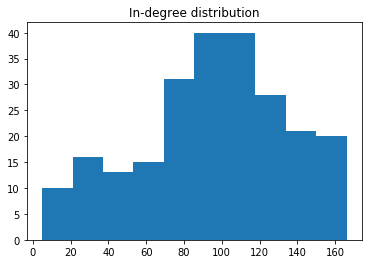

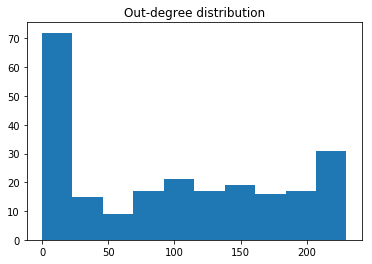

'There are 64 countries that are reported as export partners but do not report exports themselves.'

In [37]:
plot_degree_dist(G_2015)

There are 16 fewer countries reported as export partners but do not report exports themselves compared to the 2019 data.

We then identify the countries we would like to include in the visualisation. Here I find the countries in the 20 largest trading relationships involving the UK.

In [38]:
# Identify parties in large trade relationships with the UK in 2015
uk_exports_2015 = exports_2015[(exports_2015['reporter_name'] == 'United Kingdom') | 
                               (exports_2015['partner_name'] == 'United Kingdom')].nlargest(20, 
                                                                                            columns = 'export_value_in_1000_usd')

large_reporter_uk = set(uk_exports_2015['reporter_name'])
large_partner_uk = set(uk_exports_2015['partner_name'])
large_parties_uk = list(large_reporter_uk | large_partner_uk)
print(f'The countries visualised in the Brexit analysis are: '+', '.join(large_parties_uk))

The countries visualised in the Brexit analysis are: Norway, Belgium, Italy, Ireland, Netherlands, China, United States, Germany, France, United Kingdom, Switzerland, Spain


### Calculate 2015 centrality values and visualise the results

In [39]:
G_2015_centrality = centrality_table_maker(G_2015)
G_2015_centrality.head()

,in_degree_centrality,out_degree_centrality,in_closeness_centrality,out_closeness_centrality,betweenness_centrality,eigenvector_centrality,eccentricity
Afghanistan,0.399142,0.218884,0.500324,0.561446,0.002405,0.001010,2
"Hong Kong, China",0.673820,0.708155,0.677234,0.774086,0.054148,0.244709,2
India,0.660944,0.939914,0.666192,0.943320,0.000888,0.076370,2
"Iran, Islamic Rep.",0.472103,0.605150,0.537629,0.716923,0.000000,0.013209,2
Iraq,0.476395,0.042918,0.539997,0.510965,0.002941,0.009329,2


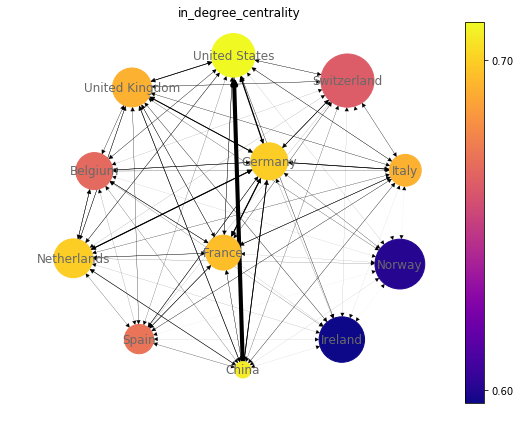

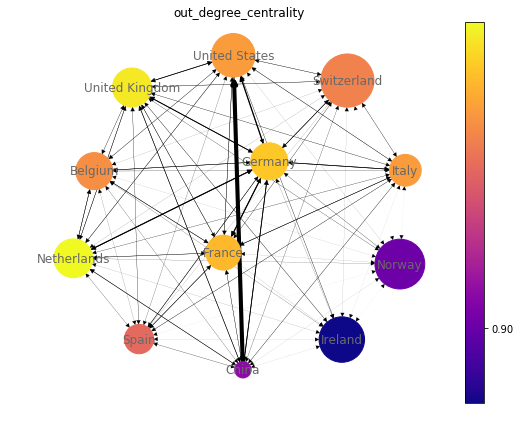

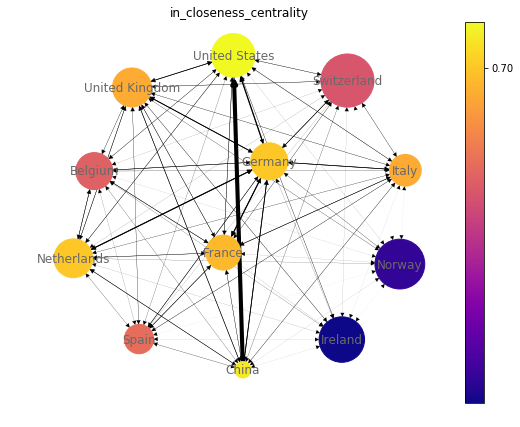

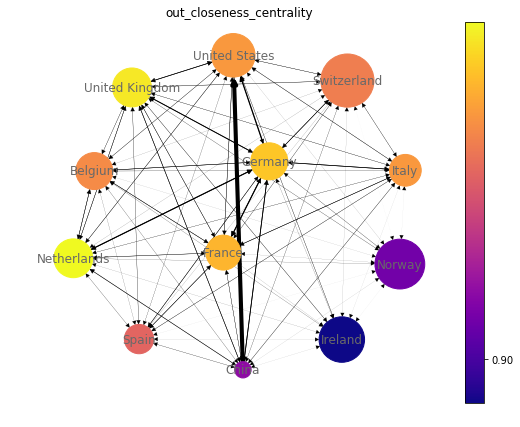

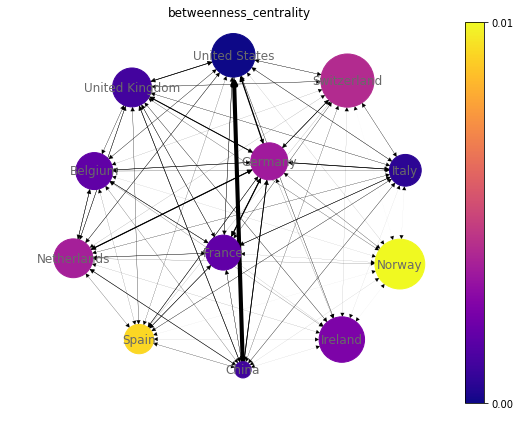

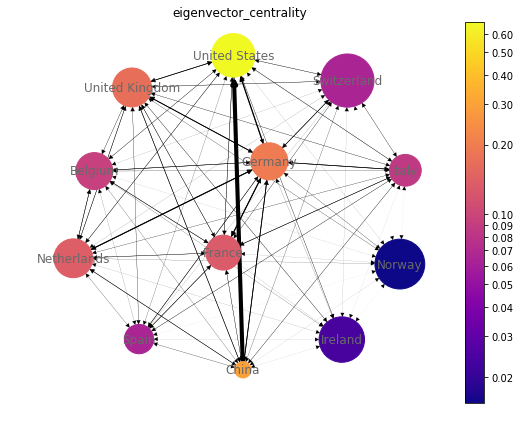

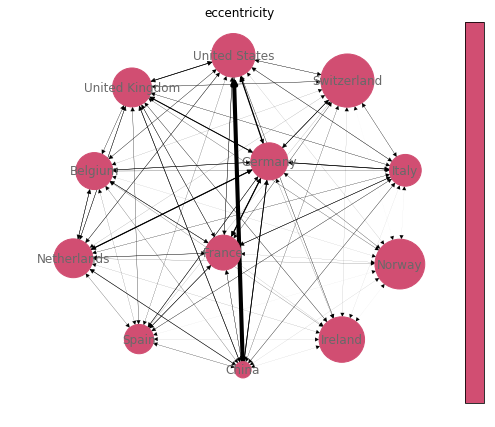

,in_degree_centrality,out_degree_centrality,in_closeness_centrality,out_closeness_centrality,betweenness_centrality,eigenvector_centrality,eccentricity
Norway,0.600858,0.901288,0.619088,0.910156,0.006234,0.015450,2
Belgium,0.665236,0.957082,0.669833,0.958848,0.001091,0.094434,2
Italy,0.690987,0.961373,0.692539,0.962810,0.000333,0.085608,2
Ireland,0.596567,0.879828,0.612897,0.889313,0.001554,0.023823,2
Netherlands,0.699571,0.987124,0.700454,0.987288,0.002257,0.136962,2
China,0.708155,0.909871,0.708551,0.917323,0.000629,0.296053,2
United States,0.712446,0.961373,0.712671,0.962810,0.000000,0.672406,2
Germany,0.699571,0.974249,0.700454,0.974895,0.002164,0.196255,2
France,0.695279,0.969957,0.696474,0.970833,0.001110,0.131913,2
United Kingdom,0.690987,0.982833,0.692539,0.983122,0.000647,0.170457,2


In [40]:
subgraph_maker(G_2015, large_parties_uk)

### Plot the 2019 data

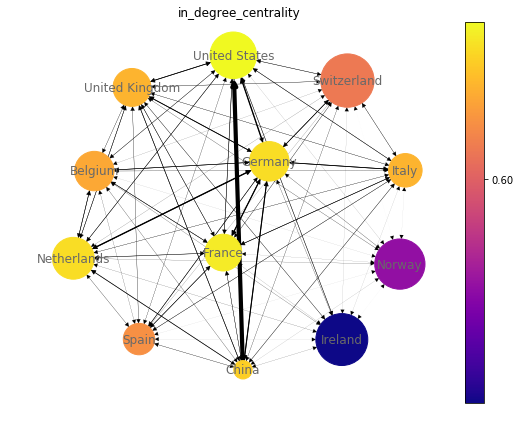

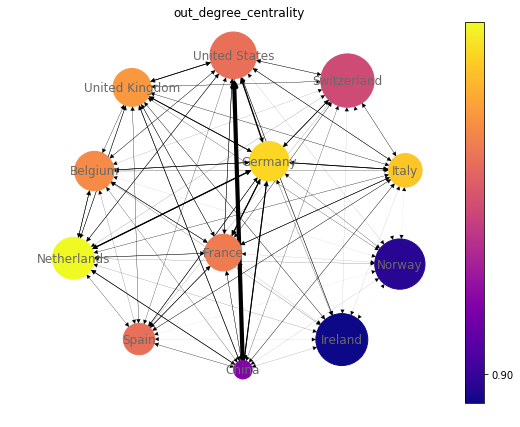

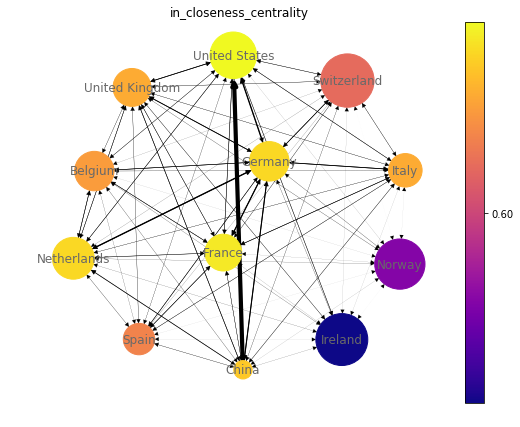

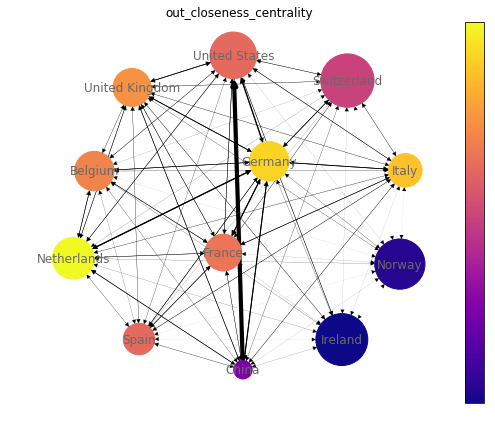

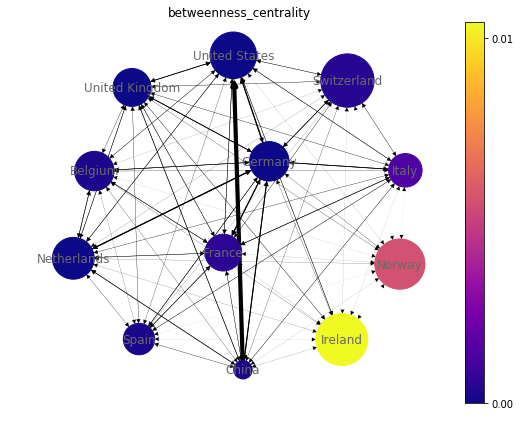

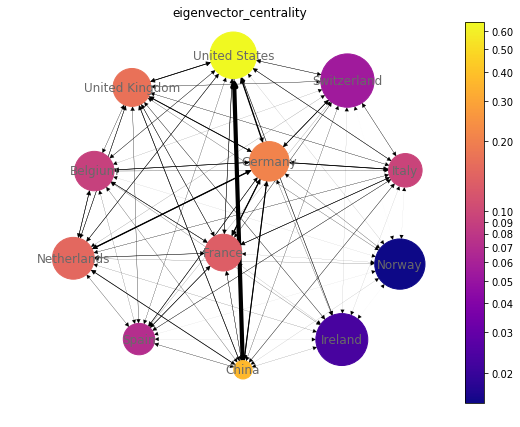

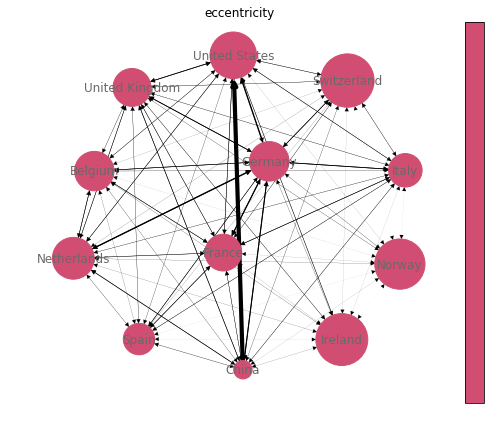

,in_degree_centrality,out_degree_centrality,in_closeness_centrality,out_closeness_centrality,betweenness_centrality,eigenvector_centrality,eccentricity
Norway,0.566524,0.896996,0.577401,0.906615,0.005550,0.014856,2
Belgium,0.626609,0.965665,0.627924,0.966805,0.000259,0.091031,2
Italy,0.630901,0.982833,0.631873,0.983122,0.001350,0.094670,2
Ireland,0.532189,0.892704,0.552021,0.903101,0.010693,0.022858,2
Netherlands,0.643777,0.995708,0.644024,0.995726,0.000000,0.150387,2
China,0.639485,0.918455,0.639922,0.924603,0.000203,0.364433,2
United States,0.652361,0.957082,0.652388,0.958848,0.000000,0.654745,2
Germany,0.643777,0.987124,0.644024,0.987288,0.000000,0.206804,2
France,0.648069,0.961373,0.648179,0.962810,0.000555,0.133816,2
United Kingdom,0.630901,0.969957,0.631873,0.970833,0.000000,0.169435,2


In [41]:
subgraph_maker(G_2019, large_parties_uk)

### Table of UK results in 2015 and 2019

In [42]:
uk_centrality = pd.DataFrame(columns = ('2015', '2019'))

uk_centrality['2019'] = G_2019_centrality.loc['United Kingdom', :]
uk_centrality['2015'] = G_2015_centrality.loc['United Kingdom', :]
uk_centrality['Change'] = uk_centrality['2019'] -  uk_centrality['2015']
uk_centrality['Change (%)'] = (( uk_centrality['2019'] -  uk_centrality['2015'] ) / uk_centrality['2019']) * 100
uk_centrality

,2015,2019,Change,Change (%)
in_degree_centrality,0.690987,0.630901,-0.060086,-9.523810
out_degree_centrality,0.982833,0.969957,-0.012876,-1.327434
in_closeness_centrality,0.692539,0.631873,-0.060666,-9.600972
out_closeness_centrality,0.983122,0.970833,-0.012289,-1.265823
betweenness_centrality,0.000647,0.000000,-0.000647,-inf
eigenvector_centrality,0.170457,0.169435,-0.001022,-0.603220
eccentricity,2.000000,2.000000,0.000000,0.000000


[Networkx documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.in_degree_centrality.html#networkx.algorithms.centrality.in_degree_centrality)  specifies that in and out degree centrality measures are normalised by dividing by N-1, where N is the number of nodes in the graph. It is therefore possible to compare the centrality measures over time with graphs of different total number of nodes (N).

The stengths and weaknesses of the centrality measures discussed earlier hold equally for this analysis. Looking at the results table, we observe that all measures of centrality for the UK decreased between 2015 and 2019. Under [Freeman's (1979)](https://www.sciencedirect.com/science/article/abs/pii/0378873378900217) interpretation of centrality as reflective of the importance or influence of nodes within a graph , the decrease in centrality reflects a decrease in the international influence of the UK within the global trade network. 

However, there are important caveats to note. In the appendix, the analysis is re-run using 2018 as the post-Brexit year. The results in this analysis are mixed with 3 measures decreasing (but to a lesser extent), 1 increasing and 2 staying constant. This may reflect the decrease in reporting countries between 2018 and 2019 observed earlier. To understand this better I would like to run the analysis on a constant group of countries, however, I was limited by time. 

An alternative interpretation may be a progressive worsening in international reputation following the Brexit vote, however, given the slow moving nature of trade deals I put less weight on this argument. 

Another potential weakness of the analysis is that because the trade system is so interconnected - relationships cease to exist in a few years - it is likely that any lost relationship is due to data incompleteness rather than economic reasoning. This issue is particularly true for non-weighted centrality measures where only the binary existance is indicated and therefore a slow decline in trade values won't be captured.

# 4. Conclusion

In this analysis I have demonstrated how social network analysis can be used to understand trade interconnectiveness and individual countries' influence using international trade data, graph theory and measures of centrality.

In the first piece of analysis looking across all countries in 2019, we were able to identify the countries with the maximum centrality values across a range of measures. Taking consideration of the strengths and weaknesses of the different centrality measures discussed above, I would consider eigenvector measures the most accurate representation of international trade importance. This would suggest that China is the most important country in international trade - a result which coincides with economic reasoning.

In the second piece of analysis, the changes in centrality measures for the United Kingdom were explored over the Brexit period. In this analysis we found that the centrality measures decreased between 2015 and 2019. However, robustness checks on the post-Brexit year provided mixed results. These mixed results are a well noted limitation of centrality measures in the SNA literature and summarised by the Krackhardt kite graph [(Krackhardt, 1990)](https://www.jstor.org/stable/2393394#metadata_info_tab_contents). In the Krackhardt kite graph, different nodes have the maximum degree, betweenness and closeness centrality. Overall, the results do not provide sufficient evidence to prove that the UK's international standing has been impacted in the years explored in the analysis. Considering the slow-moving nature of international trade deals and complexity of supply chains, it is likely the full impact of Brexit  on the United Kingdom's international standing will not yet be fully reflected in the data.

# Appendix

## a. Brexit analysis based on 2018

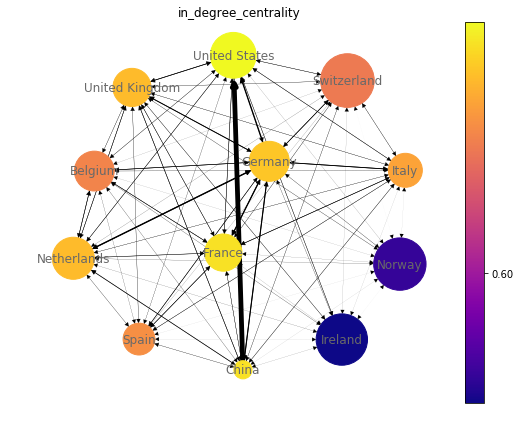

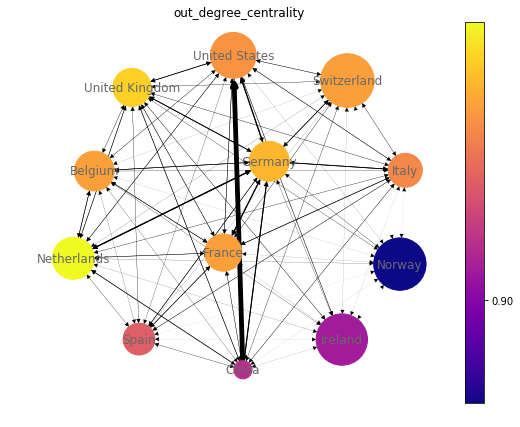

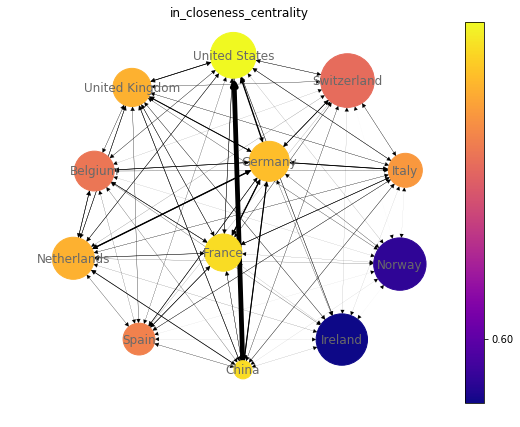

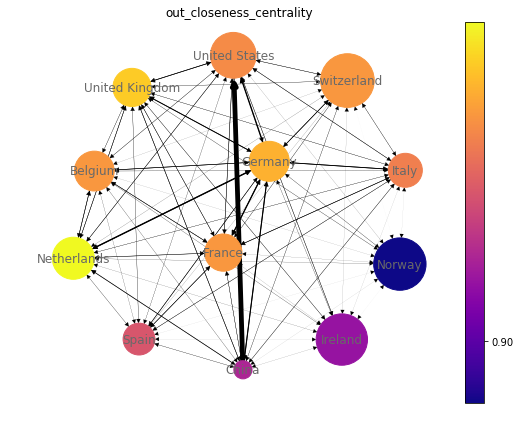

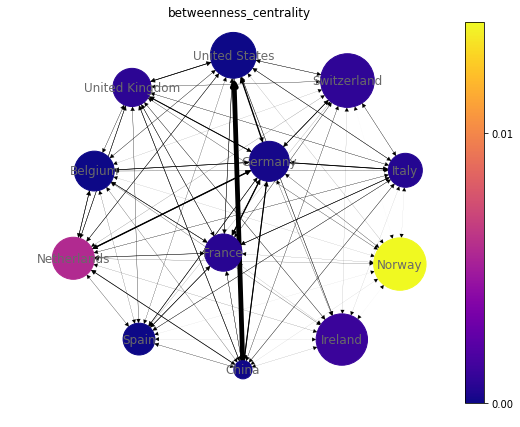

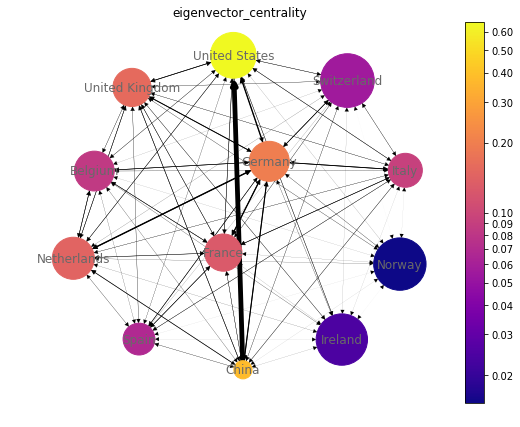

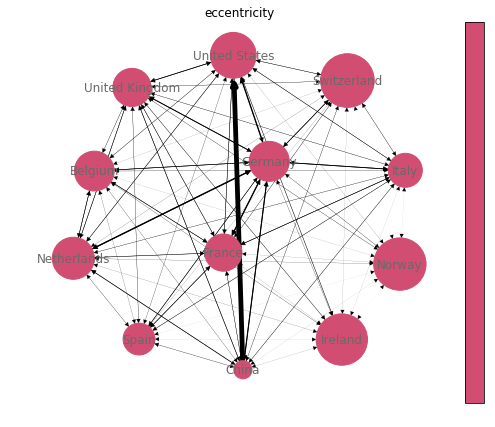

,2015,2018,Change
in_degree_centrality,0.690987,0.669528,-0.021459
out_degree_centrality,0.982833,0.982833,0.000000
in_closeness_centrality,0.692539,0.671125,-0.021414
out_closeness_centrality,0.983122,0.983122,0.000000
betweenness_centrality,0.000647,0.000740,0.000092
eigenvector_centrality,0.170457,0.155916,-0.014541
eccentricity,2.000000,2.000000,0.000000


In [43]:
# Filter exports data for 2018
exports_2018 = exports[exports['year']==2018]

# Create graph and set edge values
G_2018 = nx.from_pandas_edgelist(exports_2018,
                           source='reporter_name',
                           target='partner_name',
                           edge_attr='export_value_in_1000_usd',
                           create_using=nx.DiGraph())

# Set node values
gdp_per_cap_2018 = dict(zip(exports_2018.reporter_name, exports_2018.gdp_per_capita))
nx.set_node_attributes(G_2018, gdp_per_cap_2018, 'gdp_per_capita')

# Calculate centralities and visualise the same subset of countries
G_2018_centrality = centrality_table_maker(G_2018)
subgraph_maker(G_2018, large_parties_uk)

# Create an output table comparing UK centrality values in 2015 and 2018
uk_centrality = pd.DataFrame(columns = ('2015', '2018'))
uk_centrality['2018'] = G_2018_centrality.loc['United Kingdom', :]
uk_centrality['2015'] = G_2015_centrality.loc['United Kingdom', :]
uk_centrality['Change'] = uk_centrality['2018'] -  uk_centrality['2015']
uk_centrality

# References

Benedictis, L & Nenci, S & Santoni, G & Tajoli, L & Vicarelli, C. (2014). Network analysis of World Trade using the BACI-CEPII dataset. SSRN Electronic Journal.

Bolland, J.M. (1988) Sorting out Centrality: An Analysis of the Performance of Four Centrality Models in Real and Simulated Networks. Social Networks, 10, 233-253.

Freeman, L.C. (1979) Centrality in Social Networks Conceptual Clarification. Social Networks, 1, 215-239.

Fruchterman, J. and Reingold, M. (1991) Graph Drawing by Force-Directed Placement. Software: Practice and Experience, 21, 1129-1164.

Krackhardt, D. (1990). Assessing the Political Landscape: Structure, Cognition, and Power in Organizations. Administrative Science Quarterly, 35(2), 342–369. 

Newman. M. (2010) Networks: An Introduction. Oxford University Press, USA, pp. 169.

Sajedianfard, N., Hadian, E., Samadi, A.H. et al. (2021) Quantitative analysis of trade networks: data and robustness. Appl Netw Sci 6, 46 

Zhou, Min, (2010) 'The International Trade Network', in Ryan Light, and James Moody (eds), The Oxford Handbook of Social Networks 

# Testing

Here I run some unit tests to check the exception handling implemented in the methods above works as expected.

.

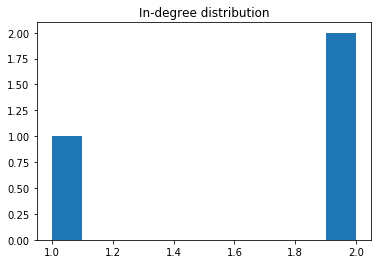

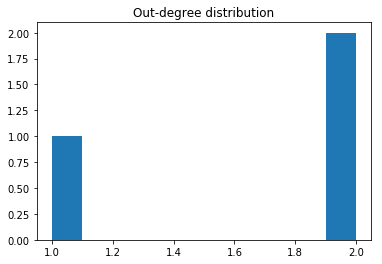

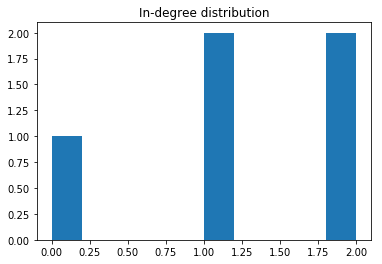

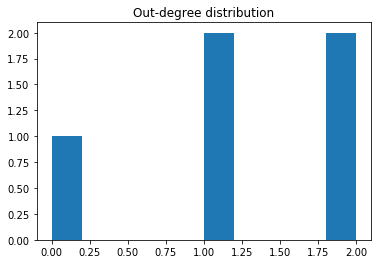

..
----------------------------------------------------------------------
Ran 3 tests in 0.420s

OK


In [44]:
class TestNotebook(unittest.TestCase):
    """
    This is a test class to test the methods defined in the code above.
    """   
    
    def setUp(self):
        
        # Set up a connected graph to be used in test methods.
        self.d = {'reporter_name':['A', 'A', 'B', 'C', 'C'],
             'partner_name':['B', 'C', 'A', 'A', 'B'],
             'export_value_in_1000_usd':[100000000,200000000,300000000,400000000,500000000],
             'gdp_per_capita':[1000,2000,30000,4000,5000]}
        self.df = pd.DataFrame(self.d)
        self.G = nx.from_pandas_edgelist(self.df,
                   source='reporter_name',
                   target='partner_name',
                   edge_attr='export_value_in_1000_usd',
                                         
                   create_using=nx.DiGraph())
        
        # Set node values for connected graph
        self.gdp_per_cap = dict(zip(self.df.reporter_name, self.df.gdp_per_capita))
        nx.set_node_attributes(self.G, self.gdp_per_cap, 'gdp_per_capita')

        # Set-up unconnected graph with missing GDP value for country E
        lst = ['D', 'E', 100000000, 30000]
        # add line to df
        self.df.loc[len(self.df)] = lst
        
        self.G_non_con = nx.from_pandas_edgelist(self.df,
                           source='reporter_name',
                           target='partner_name',
                           edge_attr='export_value_in_1000_usd',
                           create_using=nx.DiGraph())
        
        # Set node values for unconnected graph
        self.gdp_per_cap = dict(zip(self.df.reporter_name, self.df.gdp_per_capita))
        nx.set_node_attributes(self.G_non_con, self.gdp_per_cap, 'gdp_per_capita')
        
    
    # Test the outputs of plt_degree_dist function
    # The print function should have no non-reporting export partners
    def test_plot_degree_dist(self):
        self.assertEqual(plot_degree_dist(self.G), 'There are 0 countries that are reported as export partners but do not report exports themselves.')
        self.assertEqual(plot_degree_dist(self.G_non_con), 'There are 1 countries that are reported as export partners but do not report exports themselves.')
        
        # Test the output is correct when inputing incorrect argument types
        self.assertEqual(plot_degree_dist('G'), "Error: plot_degree_dist does not accept <class 'str'>. Please enter a NetworkX graph.")
        self.assertEqual(plot_degree_dist(45), "Error: plot_degree_dist does not accept <class 'int'>. Please enter a NetworkX graph.")
                  
    
    # Test centrality_table for edge case when graph is not connected
    def test_centrality_table_maker(self):
              
        # Test the output is a pandas dataframe
        assert isinstance(centrality_table_maker(self.G), pd.DataFrame)
        
        # Test the number of columns are correct under both graph types
        self.assertEqual(len(centrality_table_maker(self.G_non_con).columns), 6)
        self.assertEqual(len(centrality_table_maker(self.G).columns), 7) 
        
    # Test that an IndexError is raised when GDP data missing from subset list
    def test_subgraph_maker(self):
        subsetter_test = ['A','B','E']
        
        # Check that in Index Error is raised when GDP per capita data is missing from a subsetting country (E)
        self.assertEqual(subgraph_maker(self.G_non_con, subsetter_test), "Error: Missing GDP per capita data for: {'E'}")
            
        
unittest.main(argv=[''], verbosity=1, exit=False)

# END